# 2. 배추 모형

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

## 2.1. 모형 구현

오전에 살펴보았던 Python 기반 배추 모형을 Cropbox로 옮기면서 모형이 실제 어떻게 구현되어 있는지 알아보겠습니다.

### 2.1.1. 무름증상 (soft rot)

오전에 배웠던 순서대로라면 생물계절(phenology)부터 살펴보아야 하지만, 해당 모듈이 병해(disease) 처리에 의존하기 때문에 무름증상 관련 구현부터 살펴보겠습니다.

아래는 Python 모형의 `disease.py`에서 발췌한 코드입니다.

```python
A = 2.0
B = 4.0

class Disease(object):    
    def __init__(self):
        self.ds = 0.0                    # severity (0-1)
        self.rsum = 0.0                  # rate sum

    def calc(self, Tair, wet):      
        # calculation
        if wet and Tair > 0:
            # use modified lognormal function
            rate  = np.exp(-1*(np.log(Tair/100))**4) * conv
        else :
            rate  = 0

        self.rsum += rate
        dx   = -1 * (self.rsum / A)**B      
        ds = 1 - np.exp(dx)
        self.ds = ds
```

이를 Cropbox에서는 아래와 같이 구현할 수 있습니다. 거의 유사해보일 수도 있지만 각 변수에 대한 정의가 독립적으로 표현되는 점, 모수(parameter)를 특정할 수 있다는 점, 값의 단위가 명확히 들어간다는 점 등을 눈여겨 봐주세요.

In [3]:
@system Disease begin
    Ta  ~ preserve(parameter, override, u"°C")
    wet ~ flag(parameter, override)

    _A => 2 ~ preserve(parameter)
    _B => 4 ~ preserve(parameter)

    damaging(Ta, wet) => begin
        Ta > 0u"°C" && wet
    end ~ flag

    rate(Ta) => begin
        # use modified lognormal function
        exp(-log((Ta - 0u"°C") / 100u"K")^4)
    end ~ track(when = damaging, u"d^-1")

    rsum(rate): rate_sum ~ accumulate

    dx(rsum, _A, _B) => begin
        -(rsum / A)^B
    end ~ track

    ds(dx): severity => begin
        1 - exp(dx)
    end ~ track
end

Disease

In [4]:
@system DiseaseController(Disease, Controller) begin
    time(context.clock.time) ~ track(u"d")
end

DiseaseController

In [5]:
config_disease = @config(
    Disease => (;
        Ta  = 25,
        wet = true,
    ),
)

Config for 1 system:
  Disease
    Ta  = 25 °C
    wet = true

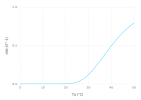

In [6]:
visualize(DiseaseController, :Ta, :rate;
    config = config_disease,
    xstep = Disease => :Ta => 0:50,
    ylim = (0,1),
    kind = :line,
)

In [7]:
manipulate(DiseaseController, :rsum, :ds;
    parameters = Disease => :Ta => 0:50,
    config = config_disease,
    stop = 100u"d",
    xlim = (0,4),
    ylim = (0,1),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Disease"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ta (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 51, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3cc81cb90, Task (runnable) @0x00007fd3cc81cb90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            

### 2.1.2. 발달 (development)

아래는 Pyhon 모형의 `stage.py`에서 발췌한 코드입니다.

```python
## parameters
# parameters for leaf number increasing
Rxleaf  = 1.838
Txleaf  = 34.7
Toleaf  = 20.57 

# temp. function sum for veg. and rep. stage
satTemp   = 30    # 54   # requirement sum of temp_rate for flowering
satRep      = 150      # requirement sum of temp_rate for harvesting
optTemp  = 15.7   # 10   # max. temp for veg. and rep, growth, (temp_rate = np.exp(-1*(np.log(temp/optTemp)**2) )   

# ver. function sum for vernalization
satVer    = 52       # 50  # sum of ver_rate for flowering
optVer    = 6.2     # 7.0   # opt. temp. for vernalization , (verrate = np.exp(-1*(np.log(temp/optVer)**4) )       

class BD(): 
    def __init__(self, initialLeafNumber, plantDensity, pLeafForm, daysRoot):
        self.leafNumber    = int(initialLeafNumber)
        self.plantDensity  = plantDensity
        self.pLeafForm     = pLeafForm
        self.daysRoot      = daysRoot
       
        self.dvs     = 0.0
        self.sumTemp = 0.0
        self.sumVer  = 0.0
        self.tempdvs = 0.0
        self.verdvs  = 0.0

        ...

## 엽수증가식 -> 정식초기(earlyRateLN), 중기(midRateLN), 무름증 후(0.0)로 구분해서 계산
## 정식초기는 평균 정식 후 14일간, 입력받아 조정 가능함(daysRoot)
    def midRateLN(self, Ta):
        # calculation leaf number
        if (Ta > 0.0) and (Ta < Txleaf): 
            leafRate = Rxleaf *((Txleaf-Ta)/(Txleaf-Toleaf))*(Ta/Toleaf)**(Toleaf/(Txleaf-Toleaf))
            leafRate = leafRate * conv
        else:
            leafRate = 0.0
        return leafRate
    
    def earlyRateLN(self, Ta):
        return self.midRateLN(Ta)*0.05
    
    ...

## 추대 모형 -> 온도를 이용해서 계산  dvs = verdvs * tempdvs
    def calcVerdvs(self, Ta):
        Ta  = max(Ta, 0.01)
        rate = np.exp(-1*(np.log(Ta/optVer)**4))
        self.sumVer += rate * conv
        self.verdvs = max(1, self.sumVer/satVer)
        
    def calcTempdvs(self, Ta):
        Ta  = max(Ta, 0.01)
        rate = np.exp(-1*(np.log(Ta/optTemp)**2))
        self.sumTemp += rate * conv
        sumTemp = self.sumTemp
        if sumTemp >= satRep:
            tempdvs = 2.0
        elif sumTemp > satTemp:
            tempdvs = 1 + (sumTemp - satTemp) /(satRep - satTemp)
        else:
            tempdvs = sumTemp / satTemp
        self.tempdvs = tempdvs
        
    def calcBD(self, Ta, dap):
        # calculation leaf number
        if dap < self.daysRoot:
            leafRate = self.earlyRateLN(Ta)
        else:
            leafRate = self.midRateLN(Ta)*self.pLeafForm
        self.leafNumber += leafRate
        leafNumber = self.leafNumber

        # calculation dvs
        self.calcVerdvs(Ta)
        self.calcTempdvs(Ta)
        self.dvs = self.tempdvs * self.verdvs

    ...
```

주요 변수들에 대한 계산이 `calcXXX()` 형식의 함수(method)로 정의되고, `calcBD()` 함수에서 각 함수들을 호출하여 계산을 수행하는 구조입니다. 그런데 그렇다면 `calcBD()` 함수는 언제 어디서 누가 불러주는 것일까요?

그 해답은 `facade.py`에 있습니다.

```python
class Facade(object):
    def __init__(self, dorh, fname_in, fname_out, start, end, iniLN, density, latitude, pLeafForm, daysRoot):
        # assign initial values
        ...

        # create instances
        self.bd = stg.BD(initialLeafNumber=iniLN, plantDensity=density,  pLeafForm=pLeafForm, daysRoot=daysRoot)
        ...

    def run(self, file_write=True):
        ...
        
        wdata = self.wthr.data
        for i, v in wdata.iterrows():
            # data retrieval from wdata dataframe
            ...

            # calculate lai and dvs from temp
            self.bd.calcBD(Tair, dap)
            self.leafNumber = self.bd.leafNumber
            LN = self.leafNumber
            
            ...
```

여기서는 facade라고 부르는, 혹은 다른 모형에서는 driver 내지는 controller와 같은 이름으로 부르기도 하는 관리자가 그 역할을 수행합니다. 이러한 관리자는 대개 입력 자료나 모수들을 읽어들인 다음, 각 모듈에서 계산을 수행하는 함수들을 호출하고 그 결과를 취합하여 저장하거나 보여주는 일을 합니다. 계산을 수행할 때는 대개 일정 기간/회수 동안 반복해야 하기 때문에 `for` 반복문 같은 구조로 구현이 됩니다. 이는 배추 모형 뿐만 아니라 다른 작물 모형들 모두 크게 다르지 않은 부분입니다.

Cropbox에서는 이렇게 명시적으로 관리자를 만들고 그 안에서 함수를 직접 호출해야 하는 부분들을 최소화합니다. 변수가 선언되면 각 변수의 의존관계에 따라 순서가 정해지고 필요한 순간에 자동으로 계산이 수행됩니다. 그리고 facade의 역할은 `simulate()` 함수가 담당하며, 모수 설정은 어제 살펴보았던 `Config` 형태로 통일되어 있습니다. 즉, 모형 개발자 입장에서는 이러한 부분을 직접 만들지 않아도 되는 것입니다.

In [8]:
@system Phenology begin
    Ta ~ preserve(parameter, override, u"°C")

    "plant density per m2"
    plantDensity ~ preserve(parameter, override, u"m^-2")

    wet ~ flag(parameter, override)

    "initial leaf number, default"
    initialLeafNumber ~ preserve(parameter)

    "days for root adaptation after transplanting"
    daysRoot ~ preserve(parameter, u"d")

    dap(context.clock.time) ~ track(u"d")
    
    # parameters for leaf number increasing
    Rxleaf => 1.838 ~ preserve(parameter, u"d^-1")
    Tnleaf => 0     ~ preserve(parameter, u"°C")
    Txleaf => 34.7  ~ preserve(parameter, u"°C")
    Toleaf => 20.57 ~ preserve(parameter, u"°C")

    "requirement sum of temp_rate for flowering"
    satTemp => 54 ~ preserve(parameter)

    "requirement sum of temp_rate for harvesting"
    satRep => 150 ~ preserve(parameter)

    "max. temp for veg. and rep, growth"
    optTemp => 10 ~ preserve(parameter, u"°C")

    "sum of ver_rate for flowering"
    satVer => 55  ~ preserve(parameter)

    "opt. temp. for vernalization"
    optVer => 7.0 ~ preserve(parameter, u"°C")

    midRateLN(Ta, Tn = Tnleaf, Tx = Txleaf, To = Toleaf, Rx = Rxleaf) => begin
        T = clamp(Ta, 0u"°C", Tx)
        Rx * ((Tx - T) / (Tx - To)) * ((T - Tn) / (To - Tn))^((To - Tn) / (Tx - To))
    end ~ track(u"d^-1")

    earlyRateLN(midRateLN) => begin
        0.5midRateLN
    end ~ track(u"d^-1")

    rateVer(nounit(Ta, u"°C"), nounit(optVer, u"°C")) => begin
        T = max(Ta, 0.01)
        exp(-log(T / optVer)^4)
    end ~ track(u"d^-1")

    sumVer(rateVer) ~ accumulate

    verdvs(sumVer, satVer) => begin
        sumVer / satVer
    end ~ track(max = 1)

    rateTemp(nounit(Ta, u"°C"), nounit(optTemp, u"°C")) => begin
        T = max(Ta, 0.01)
        exp(-log(T / optTemp)^2)
    end ~ track(u"d^-1")

    sumTemp(rateTemp) ~ accumulate

    tempdvs(sumTemp, satTemp, satRep) => begin
        if sumTemp >= satRep
            2
        elseif sumTemp > satTemp
            1 + (sumTemp - satTemp) / (satRep - satTemp)
        else
            sumTemp / satTemp
        end
    end ~ track

    leafRate(dap, daysRoot, earlyRateLN, midRateLN, pLeafForm) => begin
        if dap < daysRoot
            earlyRateLN
        else
            midRateLN * pLeafForm
        end
    end ~ track(u"d^-1")

    leafAcc(leafRate) ~ accumulate(init = initialLeafNumber)

    LN(leafAcc): leafNumber ~ track::int(round = :floor)

    dvs(tempdvs, verdvs) => begin
        tempdvs * verdvs
    end ~ track

    # from facade.py
    bolting(dvs) => begin
        !(dvs < 1)
    end ~ flag

    loss(context, Ta, wet) ~ ::Disease

    "calculate heat or disease loss"
    lossPer(loss.ds, LN) => begin
        # 변경 : 35장 -> 57장 (2021 실험 74장 => 74*0.78 = 57.7)
        if LN > 74 * 0.78
            ds * 100u"percent"
        else
            0
        end
    end ~ track(u"percent")

    initial_pLeafForm ~ preserve(parameter)

    "suppression parameter for leaf formation rate"
    pLeafForm(initial_pLeafForm, lossPer) => begin
        # 추가 : 무름증 발생 후 엽 증가속도 0.0 (2021 실험)
        #HACK: forgive very small non-zero values
        if lossPer > 0.01
            0
        else
            initial_pLeafForm
        end
    end ~ track
end

Phenology

In [9]:
@system PhenologyController(Phenology, Controller) begin
    #HACK: disable Disease module
    wet => false ~ flag
    loss         ~ :: Nothing
    lossPer => 0 ~ track(u"percent")

    pLeafForm(initial_pLeafForm) ~ track
end

PhenologyController

In [10]:
phenology_config = @config(
    Phenology => (;
        Ta                = 25,
        plantDensity      = 3.8,
        initialLeafNumber = 6,
        daysRoot          = 10,
        initial_pLeafForm = 0.69,
        
        optTemp = 10,
        optVer = 7,
        Rxleaf = 1.838,
        Tnleaf = 0,
        Txleaf = 34,
        Toleaf = 20,
    ),
)

Config for 1 system:
  Phenology
    Ta                = 25 °C
    plantDensity      = 3.8 m^-2
    initialLeafNumber = 6
    daysRoot          = 10 d
    initial_pLeafForm = 0.69
    optTemp           = 10 °C
    optVer            = 7 °C
    Rxleaf            = 1.838 d^-1
    Tnleaf            = 0 °C
    Txleaf            = 34 °C
    Toleaf            = 20 °C

#### 2.1.2.1 온도 의존

In [11]:
manipulate(PhenologyController, :Ta, :rateTemp;
    parameters = Phenology => (;
        optTemp = 0:40,
    ),
    config = phenology_config,
    xstep = :0 => :Ta => 0:50,
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["optTemp (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 41, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb189b60, Task (runnable) @0x00007fd3bb189b60), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n     

In [12]:
manipulate(PhenologyController, :dap, :tempdvs;
    parameters = Phenology => (;
        Ta = 0:50,
        optTemp = 0:40,
    ),
    config = phenology_config,
    stop = 100u"d",
    ylim = (0,2),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ta (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 51, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb18bc70, Task (runnable) @0x00007fd3bb18bc70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n          

#### 2.1.2.2 춘화 처리(vernalization)

In [13]:
manipulate(PhenologyController, :Ta, :rateVer;
    parameters = Phenology => (;
        optVer = 0:30,
    ),
    config = phenology_config,
    xstep = :0 => :Ta => 0:50,
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["optVer (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
8, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb188460, Task (runnable) @0x00007fd3bb188460), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

In [14]:
manipulate(PhenologyController, :dap, :verdvs;
    parameters = Phenology => (;
        Ta = 0:50,
        optVer = 0:30,
    ),
    config = phenology_config,
    stop = 100u"d",
    ylim = (0,1),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ta (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 51, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb1a42f0, Task (runnable) @0x00007fd3bb1a42f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n          

#### 2.1.2.3. 발달 단계 (DVS)

In [15]:
manipulate(PhenologyController, :dap, :dvs;
    parameters = Phenology => (;
        Ta = 0:50,
        optTemp = 0:40,
        optVer = 0:30,
    ),
    config = phenology_config,
    stop = 100u"d",
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Ta (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 51, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
26, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb1a4460, Task (runnable) @0x00007fd3bb1a4460), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n          

#### 2.1.2.4. 엽수

In [16]:
manipulate(PhenologyController, :Ta, :leafRate;
    parameters = Phenology => (;
        Rxleaf = 0.1:0.1:3,
        Toleaf = 10:30,
        Txleaf = 20:40,
    ),
    config = phenology_config,
    xstep = :0 => :Ta => 0:50,
    ylim = (0,2),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Rxleaf (d^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 30, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
19, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3cc81f6b0, Task (runnable) @0x00007fd3cc81f6b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n    

In [17]:
manipulate(PhenologyController, :dap, :LN;
    parameters = Phenology => (;
        Rxleaf = 0.1:0.1:3,
        Toleaf = 10:30,
        Txleaf = 20:40,
    ),
    config = phenology_config,
    stop = 30u"d",
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Phenology"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Rxleaf (d^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 30, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
19, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb634460, Task (runnable) @0x00007fd3bb634460), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n    

### 2.1.3. 엽 생장 (leaf growth)

Python 모형에서 엽 생장에 관련된 부분은 앞에서 살펴보았던 `BD` 클래스에 함께 구현되어 있습니다. 아래 정의되어 있는 함수의 순서대로 먼저 엽서(leaf rank)와 엽장(leaf length)의 분포를 만들고, 엽장에서 엽면적(leaf area)을 도출한 다음, 차례대로 엽신(leaf blade), 녹색엽수(green leaf number)을 구하여 최종적으로 녹색엽면적(green leaf area)을 계산하는 것이 목적입니다. 녹색엽면적은 이후 엽면적지수(leaf area index)로 변환되어 어제 살펴보았던 것과 같은 군락 광합성에 사용됩니다.

```python
class BD():
    ...

    def eachLenDistribution(self, leafnumber):
        eachLenDist = []
        if leafnumber < 8:
            for i in range(leafnumber):
                eachLenDist.append(1.0)
        else:
            a = 20.347*np.log(leafnumber) - 40.703
            b = 0.2086*(leafnumber) + 1.6862
            for i in range(1,leafnumber+1):
                eachLen = a * np.exp(-0.5 * ((i - b) / b)**2)
                eachLenDist.append(eachLen)
        return eachLenDist

    def eachLeafArea(self, eachLenDist):
        eachLeafArea = [0.3512*each**2 + 1.1328*each for each in eachLenDist]
        return eachLeafArea

    def eachBladeArea(self, eachLeafArea):
        ratio = [0.9217*np.exp(-0.01*order) for order in range(1, len(eachLeafArea)+1)]
        eachBladeArea = [a*b for a, b in zip(ratio, eachLeafArea)]
        return eachBladeArea

    def numGreenLeaf(self, eachBladeArea):
        numberGL = 0.9333*np.exp(-0.017*len(eachBladeArea))*len(eachBladeArea)
        numberGreenLeaf = int(numberGL)
        return numberGreenLeaf

    def plantGreenLeafArea(self, leafnumber):
        a = self.eachLenDistribution(leafnumber)
        b = self.eachLeafArea(a)
        c = self.eachBladeArea(b)
        d = self.numGreenLeaf(c)
        greenBladeArea = c[0:d]
        greenLeafArea = sum(greenBladeArea)
        return greenLeafArea
    
    ...
```

#### 2.1.3.1. 단일엽

위의 Python 모형에서 엽면적 등을 도출할 때 자세히 보시면 개별 엽 단위로 계산되는 것이 아니라 전체 엽을 한꺼번에 모아서 배열 단위로 처리하는 것을 확인할 수 있습니다. Cropbox에서는 이를 뒤집어서 개별 엽 단위로 계산을 수행한 다음 이후에 취합하는 형태로 구현하겠습니다.

In [18]:
@system Leaf begin
    i: rank       ~ preserve::int(extern)
    n: leafNumber ~ track::int(override)

    _a(n) => begin
        20.347log(n) - 40.703
    end ~ track

    _b(n) => begin
        0.2086n + 1.6862
    end ~ track

    length(i, _a, _b) => begin
        a * exp(-0.5*((i - b) / b)^2)
    end ~ track(u"cm")

    area(l = nounit(length)) => begin
        0.3512l^2 + 1.1328l
    end ~ track(u"cm^2")

    blade_area_ratio(i) => begin
        0.9217exp(-0.01i)
    end ~ track

    blade_area(r = blade_area_ratio, a = area) => begin
        r * a
    end ~ track(u"cm^2")
end

Leaf

In [19]:
@system LeafController(Leaf, Controller) begin
    i: rank       ~ preserve::int(parameter)
    n: leafNumber ~ preserve::int(parameter)
end

LeafController

##### 2.1.3.1.1. 엽서 - 엽장 (leaf rank - leaf length)

In [20]:
manipulate(LeafController, :i, :length;
    parameters = LeafController => :n => 10:100,
    xstep = :0 => :i => 1:100,
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["LeafController"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 10, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 1 listeners. Value:
55, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd42a95f990, Task (runnable) @0x00007fd42a95f990), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

##### 2.1.3.1.2. 엽장 - 엽면적 (leaf length - leaf area)

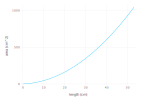

In [21]:
visualize(LeafController, :length, :area;
    config = :0 => :n => 100,
    xstep = :0 => :i => 1:100,
    kind = :line,
)

In [22]:
manipulate(LeafController, :i, :area;
    parameters = LeafController => :n => 10:100,
    xstep = :0 => :i => 1:100,
    ylim = (0,1000),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["LeafController"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 10, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 1 listeners. Value:
55, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb8b8fe0, Task (runnable) @0x00007fd3bb8b8fe0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

##### 2.1.3.1.3. 엽신 (leaf blade)

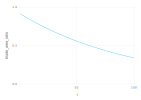

In [23]:
visualize(LeafController, :i, :blade_area_ratio;
    config = :0 => :n => 100,
    xstep = :0 => :i => 1:100,
    ylim = (0,1),
    kind = :line,
)

In [24]:
manipulate(LeafController, :i, :blade_area;
    parameters = LeafController => :n => 10:100,
    xstep = :0 => :i => 1:100,
    ylim = (0,1000),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["LeafController"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 10, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 1 listeners. Value:
55, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd42b2626e0, Task (runnable) @0x00007fd42b2626e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

#### 2.1.3.2. 전체엽

이제 여러 개의 잎을 만들어서 총면적을 계산해보도록 하겠습니다.

총 엽수(`leafNumber`)는 앞의 `Phenology` 시스템에서 계산되어 넘어올 예정이기 때문에 여기서는 임의의 모수(parameter)라고 가정합니다. 개별엽을 나타내는 `Leaf` 시스템은 `produce` 패턴에 의해 총 엽수만큼 생성되어 `leaves`(`L`) 변수에 배열 형태로 저장됩니다. 총엽수는 시간이 지남에 따라 증가하기 때문에 현재 엽수의 차이를 확인하여 필요한 경우 새로운 엽을 생성하여 추가하는 구조입니다.

총 녹색엽면적(`plantGreenLeafArea`)는 접체 엽 중에서 녹색엽인 것들만 추려낸 다음(`numGreenLeaf`), 해당 엽들의 엽신(leaf blade) 면적을 모두 더하는(`sum()`) 것으로 계산합니다. 이렇게 계산된 면적을 재식밀도(plant density; `plantDensity`)로 곱해주면 엽면적지수(leaf area index; `lai`)를 구할 수 있습니다.

In [25]:
@system Morphology begin
    leafNumber   ~ preserve::int(parameter, override)
    plantDensity ~ preserve(parameter, override, u"m^-2")

    L(L, wrap(leafNumber), n1 = leafNumber): leaves => begin
        n = length(L)
        [produce(Leaf; rank = i, leafNumber) for i in (n+1):n1]
    end ~ produce::Leaf[]

    numGreenLeaf(n = leafNumber) => begin
        0.9333exp(-0.017n) * n 
    end ~ track::int(round = :floor)

    plantGreenLeafArea(A = L["*"].blade_area, n = numGreenLeaf) => begin
        x = min(length(A), n)
        sum(A[1:x])
    end ~ track(u"cm^2")

    lai(a = plantGreenLeafArea, d = plantDensity) => begin
        a * d
    end ~ track(u"cm^2/cm^2")
end

Morphology

In [26]:
@system MorphologyController(Morphology, Controller)

MorphologyController

In [27]:
config_morpho = @config(
    Morphology => (;
        leafNumber = 10,
        plantDensity = 3.8,
    ),
)

Config for 1 system:
  Morphology
    leafNumber   = 10
    plantDensity = 3.8 m^-2

##### 2.1.3.2.1. 녹색엽수 (number of green leaf)

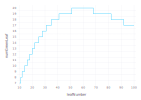

In [28]:
visualize(MorphologyController, :leafNumber, :numGreenLeaf;
    config = config_morpho,
    xstep = Morphology => :leafNumber => 10:100,
    kind = :step,
)

##### 2.1.3.2.2. 녹색엽면적 (green leaf area)

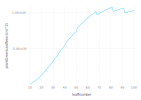

In [29]:
visualize(MorphologyController, :leafNumber, :plantGreenLeafArea;
    config = config_morpho,
    xstep = Morphology => :leafNumber => 10:100,
    stop = 1,
    snap = s -> s.context.clock.time' == 1u"hr",
    kind = :line,
)

### 2.1.4. 광합성 (gas-exchange)

광합성은 어제 다루었던 내용과 동일합니다. 코드가 많기 때문에 노트북에 직접 입력하지 않고 외부에 저장해놓은 소스 파일을 읽어서 사용하겠습니다.

In [30]:
include("src/vaporpressure.jl")
include("src/weather.jl");

In [31]:
include("src/gasexchange/diffusion.jl")
include("src/gasexchange/nitrogen.jl")
include("src/gasexchange/base.jl")
include("src/gasexchange/c3.jl")
include("src/gasexchange/boundarylayer.jl")
include("src/gasexchange/stomata.jl")
include("src/gasexchange/intercellularspace.jl")
include("src/gasexchange/irradiance.jl")
include("src/gasexchange/energybalance.jl");

In [32]:
@system ModelBase(
    Weather, Nitrogen,
    BoundaryLayer, StomataBase, IntercellularSpace, Irradiance, EnergyBalance
)

ModelBase

In [33]:
@system GasExchangeBase(ModelBase, StomataBallBerry, C3) begin
    PPFD: photosynthetic_photon_flux_density ~ preserve(parameter, override, u"μmol/m^2/s" #= Quanta =#)
end

GasExchangeBase

In [34]:
@system GasExchange(GasExchangeBase) begin
    weather ~ bring::WeatherData(override)
end

GasExchange

In [35]:
@system GasExchangeBaseController(GasExchangeBase, Controller)

GasExchangeBaseController

배추에서 측정합 광합성 모수를 설정해줍니다.

In [36]:
config_ge = @config(
    GasExchangeBase => (;
        # other common parameters
        g0 = 0.036,
        g1 = 10.0,

        # parameters for water stress
        sf = 0.5,
        Ψf = -1.0,

        # parameters for Chinese cabbage from Experiment 2015
        θ = 0.7, # hyperbola parameter
        w = 10, # leaf width (cm)
        Vcm25 = 152.5,
        Jm25 = 238.6,
        Tp25 = 17.1,
        Rd25 = 1.7,
        Γ25 = 42.8,
        EaVc = 65.33,
        #Hv = 149.252,
        #Sv = 486,
        Eaj = 57.5,
        Hj = 439.8,
        Sj = 1400,
        Ear = 46.39,
        Eag = 37.83,
        EaTp = 47.1,
    ),
    GasExchangeBase => (;
        PPFD = 1000,
    ),
    Weather => (;
        PFD = 1000,
        T_air = 25,
        rain = 0,
        wind = 2,
        RH = 70,
        CO2 = 400,
        P_air = 101.3,
        lat = 37.0,
    ),
)

Config for 2 systems:
  GasExchangeBase
    g0    = 0.036 mol bar^-1 m^-2 s^-1
    g1    = 10.0
    sf    = 0.5 MPa^-1
    Ψf    = -1.0 MPa
    θ     = 0.7
    w     = 10 cm
    Vcm25 = 152.5 μmol m^-2 s^-1
    Jm25  = 238.6 μmol m^-2 s^-1
    Tp25  = 17.1 μmol m^-2 s^-1
    Rd25  = 1.7 μmol m^-2 s^-1
    Γ25   = 42.8 μbar
    EaVc  = 65.33 kJ mol^-1
    Eaj   = 57.5 kJ mol^-1
    Hj    = 439.8 kJ mol^-1
    Sj    = 1400 J K^-1 mol^-1
    Ear   = 46.39 kJ mol^-1
    Eag   = 37.83 kJ mol^-1
    EaTp  = 47.1 kJ mol^-1
    PPFD  = 1000 μmol m^-2 s^-1
  Weather
    PFD   = 1000 μmol m^-2 s^-1
    T_air = 25 °C
    rain  = 0 mm
    wind  = 2 m s^-1
    RH    = 70 %
    CO2   = 400 μmol mol^-1
    P_air = 101.3 kPa
    lat   = 37.0°

In [37]:
manipulate(GasExchangeBaseController, :Ci, [:A_net, :Ac, :Aj, :Ap];
    parameters = GasExchangeBase => (;
        PPFD = 0:10:2000,
        T_air = 0:50,
    ),
    config = config_ge,
    xstep = :0 => :CO2 => 10:10:1500,
    xlim = (0,1000),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["GasExchangeBase"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["PPFD (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
101, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd42ab92400, Task (runnable) @0x00007fd42ab92400), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n              

In [38]:
manipulate(GasExchangeBaseController, :PPFD, [:A_net, :Ac, :Aj, :Ap];
    parameters = GasExchangeBase => (;
        CO2 = 10:10:1000,
        T_air = 0:50,
    ),
    config = config_ge,
    xstep = :0 => :PPFD => 0:20:2000,
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["GasExchangeBase"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb188a20, Task (runnable) @0x00007fd3bb188a20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                con

In [39]:
manipulate(GasExchangeBaseController, :T_air, [:A_net, :Ac, :Aj, :Ap];
    parameters = GasExchangeBase => (;
        CO2 = 10:10:1000,
        PPFD = 0:10:2000,
    ),
    config = config_ge,    
    xstep = :0 => :T_air => -10:1:50,
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["GasExchangeBase"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2 (μmol mol^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb1a66e0, Task (runnable) @0x00007fd3bb1a66e0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                con

참고로, 고온에서 `Ac` 값이 이상해지는 부분은 기공전도도(`gs`)가 정해진 최소값(`g0`)에서 더 내려가지 못해 발생하는 현상임을 확인할 수 있습니다.

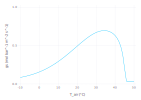

In [40]:
visualize(GasExchangeBaseController, :T_air, :gs;
    config = config_ge,
    xstep = :0 => :T_air => -10:1:50,
    kind = :line,
)

### 2.1.5. 광합성 확장 (scale-up)

군락 광합성으로의 확장 역시 어제 다루었던 부분과 유사합니다. 어제 만들었던 `Sun`과 `Radiation` 시스템을 합쳐놓은 것과 같은 `Fraction` 시스템을 사용하고 있습니다.

In [41]:
"from de Pury(1997) method"
@system Fraction begin
    lat  ~ preserve(parameter, override, u"°")
    P    ~ preserve(parameter, override, u"kPa")
    lai  ~ preserve(parameter, override, u"cm^2/cm^2")
    PPFD ~ preserve(parameter, override, u"μmol/m^2/s")
    doy  ~ preserve::int(parameter, override, u"d")
    hour ~ preserve(parameter, override, u"hr")

    ## Constants
    #TODO: remove unused constants/parameters

    "Kelvin temperature"
    KELVIN => 0u"°C" ~ preserve(u"K")

    "ideal gas constant"
    R => u"R" ~ preserve(u"J/K/mol")

    "Stefan-Boltzmann constant   W m-2 K-4"
    SBC => u"σ" ~ preserve(u"W/m^2/K^4")

    "psychrometer constant"
    PSC => 6.66e-4 ~ preserve

    "specific heat of air    J mol-1 C-1"
    Cp => 29.3 ~ preserve(u"J/mol/K")

    "Latent heat of vaporization at 25 C J mol-1"
    LAMBDA => 44 ~ preserve(u"kJ/mol")

    "Solar conatant   W m-2"
    SC: solar_constant => 1361 ~ preserve(u"W/m^2", parameter)

    "conversion from W m-2 to umol m-2 s-1"
    conv => 4.57 ~ preserve(u"μmol/J")

    ### Parameters of Chinese cabbage
    "residual leaf N content (abour 0.5% N) mmol m-2  from de Pury(1997)"
    Nb => 25 ~ preserve(u"mmol/m^2")

    "leaf N content of canopy top         mmol m-2"
    No => 137 ~ preserve(u"mmol/m^2")

    "leaf N content per unit leaf area    mmol m-2"
    Nl => 120 ~ preserve(u"mmol/m^2")

    "coefficient for leaf N allocation"
    kn => 0.713 ~ preserve

    "rubisco capacity by calculation      umol m-2 s-1 from de Pury(1997)"
    Vcmax => 110 ~ preserve(u"μmol/m^2/s")

    ## init

    "atomopheric pressure at sea level  kPa "
    Po => 101.3 ~ preserve(u"kPa")

    "clumping factor"
    clump => 0.5 ~ preserve

    ## parameters for radiation fractionation from de Pury(1997)

    "atmospheric transmission coefficients of PAR"
    a => 0.72 ~ preserve(parameter)

    "forward scattering coeff of PAR"
    fa => 0.426 ~ preserve(parameter)

    "canopy reflection coeff for diffuse PAR"
    rhocd => 0.036 ~ preserve(parameter)

    "reflection coeff of a canopy with horizontal leaves"
    rhoh => 0.04 ~ preserve(parameter)

    "reflection coeff for PAR"
    rhol => 0.10 ~ preserve(parameter)

    "leaf transmissivity to PAR"
    taul => 0.05 ~ preserve(parameter)

    "leaf scattering coeff for PAR (rhol + taul)"
    sigma => 0.15 ~ preserve(parameter)

    "diffuse PAR extinction coeff"
    kd(clump) => (0.78 * clump) ~ preserve

    "diffuse & scattered diffuse OAR ext coeff"
    kdprime => 0.719 ~ preserve(parameter)
    
    ## calc values

    "sun declination   rad"
    decl(doy) => begin
        -23.45u"°" * cos(2π * (doy + 10u"d") / 365u"d")
    end ~ track(u"rad")

    "hour angle   rad"
    ha(hour) => begin
        2π / 24u"hr" * (hour - 12u"hr")
    end ~ track(u"rad")

    "sun inclination   rad"
    incl(decl, lat, ha) => begin
        sin_a = sin(decl) * sin(lat)
        cos_b = cos(decl) * cos(lat)
        acos(sin_a + cos_b * cos(ha))
    end ~ track(u"rad")

    "solar height   rad"
    sunhgt(incl) => begin
        π/2 - incl
    end ~ track(min = 0.05, u"rad")

    "beam radiation extinction coeff"
    kb(sunhgt, clump) => begin
        0.5 / sin(sunhgt) * clump
    end ~ track

    "beam + scattered beam PAR ext coeff"
    kbprime(sunhgt) => begin
        0.46 / sin(sunhgt)
    end ~ track

    "canopy reflec coeff for beam PAR"
    rhocb(rhoh, kb) => begin
        1 - exp(-2rhoh * kb / (1 + kb))
    end ~ track

    "optical air mass"
    m(P, Po, sunhgt) => begin
        P / Po / sin(sunhgt)
    end ~ track

    "fraction of diffuse irradiance"
    fd(a, m, fa) => begin
        (1 - a^m) / (1 + a^m * (1 / fa - 1))
    end ~ track

    ## Calculation of PAP fractionation

    ## For rad fractionation, not consider scattering because it will consider in gasexchange step

    "PAR total (PAR umol m-2 s-1)"
    It(PPFD) ~ track(u"μmol/m^2/s")

    "diffuse fraction of irradiance PAR umol m-2 s-1"
    Id(It, fd) => (It * fd) ~ track(u"μmol/m^2/s")

    "beam fraction of irradiance PAR umol m-2 s-1"
    Ib(It, Id) => (It - Id) ~ track(u"μmol/m^2/s")

    ## for total leaves

    "canopy absorbed beam irrad"
    Icbs(Ib, rhocb, kbprime, lai) => begin
        Ib * (1 - rhocb) * (1 - exp(-kbprime * lai))
    end ~ track(u"μmol/m^2/s")

    "canopy absorbed diffuse irrad"
    Icd(Id, rhocd, kdprime, lai) => begin
        Id * (1 - rhocd) * (1 - exp(-kdprime * lai))
    end ~ track(u"μmol/m^2/s")

    "canopy absorbed total irrad"
    Ic(Icbs, Icd) => (Icbs + Icd) ~ track(u"μmol/m^2/s")

    ## for sunlit leaves

    "absorbed direct beam by sunlit leaves"
    Icdb(Ib, sigma, kb, lai) => begin
        Ib * (1 - sigma) * (1 - exp(-kb * lai))
    end ~ track(u"μmol/m^2/s")

    "absorbed diffse beam by sunlit leaves"
    Icdf(Id, rhocd, kdprime, kb, lai) => begin
        Id * (1 - rhocd) * (1 - exp(-(kdprime + kb) * lai)) * kdprime / (kdprime + kb)
    end ~ track(u"μmol/m^2/s")

    "absorbed scattered beam by sunlit leaves"
    Icsc(Ib, rhocb, kbprime, kb, sigma, lai) => begin
        Ib * ((1 - rhocb) * (1 - exp(-(kbprime + kb) * lai)) * kbprime / (kbprime + kb) - (1 - sigma) * (1 - exp(-2kb * lai)) / 2)
    end ~ track(u"μmol/m^2/s")

    "PAR of sunlit leaf"
    Icsun(Icdb, Icdf, Icsc) => (Icdb + Icdf + Icsc) ~ track(u"μmol/m^2/s")

    ## for shaded leaves

    "absorbed diffuse beam by shaded leaves"
    Icshdf(Id, rhocd, kdprime, lai, kb) => begin
        Id * (1 - rhocd) * (1 - exp(-kdprime * lai) - (1 - exp(-(kdprime + kb) * lai)) * kdprime / (kdprime + kb))
    end ~ track(u"μmol/m^2/s")

    "absorbed scattered beam by shaded leaves"
    Icshsc(Ib, rhocb, kbprime, kb, sigma, lai) => begin
        Ib * ((1 - rhocb) * (1 - exp(-kbprime * lai) - (1 - exp(-(kbprime + kb) * lai)) * kbprime / (kbprime + kb)) - (1 - sigma) * (1 - exp(-kb * lai) - (1 - exp(-2kb * lai)) / 2))
    end ~ track(u"μmol/m^2/s")

    "PAR of shaded leaf"
    Icsh(Icshdf, Icshsc) => (Icshdf + Icshsc) ~ track(u"μmol/m^2/s")

    ## LAI fractionation

    "LAI for sunlit leaf"
    laiSun(kb, lai) => begin
        (1 - exp(-kb * lai)) / kb
    end ~ track(u"cm^2/cm^2")

    "LAI for shaded leaf"
    laiSh(lai, laiSun) => begin
        lai - laiSun
    end ~ track(u"cm^2/cm^2")

    ## Rubisco fractionation

    "ratio of rubisco capacity to leaf N"
    Xn(Vcmax, Nl, Nb) => (Vcmax / (Nl - Nb)) ~ track(u"s^-1")

    "leaf N profile of canopy mmol m-2"
    Nc(lai, No, Nb, kn) => begin
        lai * ((No - Nb) * (1 - exp(-kn)) / kn + Nb)
    end ~ track(u"mmol/m^2")

    "Vcmax of whole canopy umol m-2 -s"
    Vcmaxtot(lai, Xn, No, Nb, kn) => begin
        lai * Xn * (No - Nb) * (1 - exp(-kn)) / kn
    end ~ track(u"μmol/m^2/s")

    "Vcmax of sunlit leaves umol m-2 -s"
    Vcsun(lai, Xn, No, Nb, kn, kb) => begin
        lai * Xn * (No - Nb) * (1 - exp(-kn - kb * lai)) / (kn + kb * lai)
    end ~ track(u"μmol/m^2/s")

    "Vcmax of shaded leaves umol m-2 -s"
    Vcsh(Vcmaxtot, Vcsun) => (Vcmaxtot - Vcsun) ~ track(u"μmol/m^2/s")
end

Fraction

### 2.1.5. 분배 (partitioning)

In [42]:
@system Growth begin
    assim ~ preserve(parameter, override, u"g/m^2/hr")
    dvs ~ preserve(parameter, override)
    Ta ~ preserve(parameter, override, u"°C")

    ## parameters

    # Parameters for Chinese cabbage
    "base temperature"
    Tbase => 0.0 ~ preserve(parameter, u"°C")

    "max root depth"
    dm => 0.6 ~ preserve(parameter, u"m")

    "root elongation rate (m/day)"
    dg => 0.012 ~ preserve(parameter, u"m/d")

    "mean plant height (m)"
    hgt => 0.4 ~ preserve(parameter, u"m")

    "mean leaf width (m)"
    width => 0.20 ~ preserve(parameter, u"m")

    "lai critical for leaf death"
    laicr => 3 ~ preserve(parameter)

    # Constants for maintenace respiration at 25C for various plant parts
    "for green leaves (gCH2O/gDM/day)"
    kgl => 0.03 ~ preserve(parameter, u"g/g/d")

    "for root (gCH2O/gDM/day)"
    kr => 0.015 ~ preserve(parameter, u"g/g/d")

    "for rep. org"
    ko => 0.020 ~ preserve(parameter, u"g/g/d")

    # Glucose requirement for synthesis of various plant parts 
    "for green leaves (gCH2O/gDM)"
    ggl => 1.463 ~ preserve(parameter, u"g/g")

    "for root (gCH2O/gDM)"
    gr => 1.444 ~ preserve(parameter, u"g/g")

    go => 1.463 ~ preserve(parameter, u"g/g")

    # Table for partitioning
    #istage = [0.00, 0.50, 0.95, 1.00, 1.10, 2.00]         # stage
    "green leaf ratio"
    ifgl => [
        0.00 => 0.92,
        0.50 => 0.93,
        0.95 => 0.94,
        1.00 => 0.70,
        1.10 => 0.00,
        2.00 => 0.00,
    ] ~ interpolate(parameter)

    "root ratio"
    ifr => [
        0.00 => 0.08,
        0.50 => 0.07,
        0.95 => 0.05,
        1.00 => 0.00,
        1.10 => 0.00,
        2.00 => 0.00,
    ] ~ interpolate(parameter)

    ifo => [
        0.00 => 0.00,
        0.50 => 0.00,
        0.95 => 0.01,
        1.00 => 0.30,
        1.10 => 1.00,
        2.00 => 1.00,
    ] ~ interpolate(parameter)

    # ratio to DM / CH2O
    "factor convert mass to CH2O weght, = mass * 45%C / C_MW * CH2O_MW"
    cd => 1.125 ~ preserve(parameter)

    "ratio of fresh weight to dry weight of leaf"
    FDR => 16.76 ~ preserve

    RDT => 1.0 ~ preserve(parameter)

    ## variables

    assim_c(assim, RDT) => begin
        assim * RDT
    end ~ track(u"g/m^2/hr")

    rgrow(dm, dg, RDT) => begin
        #HACK: logical error in the original model?
        #min(dm, dg * RDT)
        dg * RDT
    end ~ track(u"m/d")

    #HACK: use `max = dm` here
    "root depth by elongation (m)"
    rootd(rgrow) ~ accumulate(max = dm, u"m")

    "leaf death rate by old age(dvs > 1.0)"
    ddage(dvs) => begin
        if 0.9 < dvs < 1.9
            0.05 / (2.0 - dvs)
        elseif 1.9 <= dvs
            0.05 / 0.1
        else
            0.0
        end
    end ~ track

    # calculaltion green leaves, death leaves, stem, root, storage (g CH2O)
    wgl(gr_gl, gr_dl) => (gr_gl - gr_dl) ~ accumulate(u"g/m^2")
    wr(gr_r) ~ accumulate(u"g/m^2")
    wo(gr_o) ~ accumulate(u"g/m^2")

    # calculation of maintenances respiration (g CH2O)
    mgl(wgl, kgl) => (wgl * kgl) ~ track(u"g/m^2/hr")
    mr(wr, kr) => (wr * kr) ~ track(u"g/m^2/hr")
    mo(wo, ko) => (wo * ko) ~ track(u"g/m^2/hr")

    RM(mgl, mo) => (mgl + mo) ~ track(u"g/m^2/hr")

    "temperature correction from Teh"
    tempRM(RM, Ta) => begin
        RM * 2^((Ta - 10u"°C") / 10u"K")
    end ~ track(u"g/m^2/hr")

    RMpr(tempRM, assim_c) => begin
        min(tempRM, assim_c)
    end ~ track(u"g/m^2/hr")

    # calculation of growth respiration (g CH2O)
    fgl(dvs, ifgl) => ifgl(dvs) ~ track
    fr(dvs, ifr) => ifr(dvs) ~ track
    fo(dvs, ifo) => ifo(dvs) ~ track

    # normalization of all partitioning
    fggl(fgl, ggl) => (fgl * ggl) ~ track
    fgr(fr, gr) => (fr * gr) ~ track
    fgo(fo, go) => (fo * go) ~ track
    GT(fggl, fgr, fgo) => (fggl + fgr + fgo) ~ track

    "available assim per hour (g DW)"
    available(assim_c, RMpr, GT) => begin
        0.84 * (assim_c - RMpr) / GT
    end ~ track(u"g/m^2/hr")

    "for green leaves DW"
    gr_gl(fgl, available) => (fgl * available) ~ track(u"g/m^2/hr")

    "for root DW"
    gr_r(fr, available) => (fr * available) ~ track(u"g/m^2/hr")

    "for rep. organ"
    gr_o(fo, available) => (fo * available) ~ track(u"g/m^2/hr")

    "death leaf weight by aging"
    gr_dl => 0 ~ track(u"g/m^2/hr")

    maint(assim_c, available) => (assim_c - available) ~ track(u"g/m^2/hr")
end

Growth

In [43]:
@system GrowthController(Growth, Controller) begin
    time(context.clock.time) ~ track(u"d")
end

GrowthController

In [44]:
config_growth = @config(
    Growth => (;
        assim = 10,
        dvs = 0.5,
        Ta = 25,
    ),
)

Config for 1 system:
  Growth
    assim = 10 g hr^-1 m^-2
    dvs   = 0.5
    Ta    = 25 °C

In [45]:
manipulate(GrowthController, :time, :rootd;
    parameters = Growth => (;
        dm = 0:0.1:1,
        dg = 0:0.01:0.1,
    ),
    config = config_growth,
    stop = 30u"d",
    ylim = (0,100),
    yunit = u"cm",
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Growth"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["dm (m)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 11, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3bb665cd0, Task (runnable) @0x00007fd3bb665cd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\

In [46]:
manipulate(GrowthController, :time, [:assim_c, :available, :maint];
    parameters = Growth => (;
        assim = 0:20,
        Ta = 0:50,
    ),
    config = config_growth,
    stop = 30u"d",
    ylim = (0,20),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Growth"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["assim (g hr^-1 m^-2)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd42974ca20, Task (runnable) @0x00007fd42974ca20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n

In [47]:
manipulate(GrowthController, :time, [:wgl, :wr, :wo];
    parameters = Growth => (;
        dvs = 0:0.1:2,
        Ta = 0:50,
    ),
    config = config_growth,
    stop = 10u"d",
    ylim = (0,1000),
    ylab = "Dry Weight",
    names = ["Green Leaves", "Root", "Storage"],
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Growth"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["dvs"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
6, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd3ceae7c70, Task (runnable) @0x00007fd3ceae7c70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n  

### 2.1.6. 통합

지금까지 만든 시스템들을 모두 연결하여 배추 모형을 만들 수 있습니다.

In [48]:
@system Plant begin
    plantDensity ~ preserve(parameter, u"m^-2")

    date(calendar.time)          ~ track::datetime
    time(context.clock.time)     ~ track(u"d")
    doy(time)                    ~ track::int(round = :floor, u"d")
    hour(time) => (time % 1u"d") ~ track(u"hr")

    cal(context): calendar                                                    ~ ::Calendar
    wea(context, calendar): weather                                           ~ ::WeatherData
    pheno(context, Ta = wea.T_air, plantDensity, wet): phenology              ~ ::Phenology
    morpho(context, leafNumber, plantDensity): morphology                     ~ ::Morphology
    fr(context, lat = wea.lat, P = wea.P_air, lai, PPFD = wea.PFD, doy, hour) ~ ::Fraction

    ge_sun(context, weather, PPFD = fr.Icsun) ~ :: GasExchange
    ge_sh(context, weather, PPFD = fr.Icsh)   ~ :: GasExchange

    "from umolCO2 m-2leaf s-1 to umolCO2 m-2ground s-1"
    netA(Ansun = ge_sun.A_net, Ansh = ge_sh.A_net, LAIsun = fr.laiSun, LAIsh = fr.laiSh) => begin
        Ansun * LAIsun + Ansh * LAIsh
    end ~ track(u"μmol/m^2/s")

    "convert CO2 umol m-2gr s-1 to CH2O g m-2gr hr-1"
    assim(netA) => begin
        netA * 30u"g/mol"
    end ~ track(u"g/m^2/hr")

    "assimilate summation"
    assimSum(assim) ~ accumulate(u"g/m^2")

    part(context, assim, dvs, Ta = wea.T_air) ~ ::Growth

    "DW per plant"
    pltDW(leaf = part.wgl, plantDensity) => (leaf / plantDensity) ~ track(u"g")

    "convert DW to FW"
    FDratio(LN) => (6.949log(LN) - 6.5953) ~ track

    "FW per plant"
    pltFW(FDratio, pltDW) => (FDratio * pltDW) ~ track(u"g")

    count(wea.rain) => begin
        if rain > 0u"mm"
            7u"d/hr"
        else
            -1u"hr/hr"
        end
    end ~ accumulate(min = 0u"d", max = 7u"d", u"d")

    #TODO: relocate
    "determine wet or dry regime  (for 7 days after rain and rh > 98)"
    wet(count, wea.RH) => begin
        count > 0u"d" || RH >= 98u"percent"
    end ~ flag

    "FW per plant after loss"
    realFW(pltFW, pheno.lossPer) => begin
        pltFW * (1 - lossPer)
    end ~ track(u"g")

    LN(pheno.LN): leafNumber ~ track::int
    dvs(pheno.dvs)           ~ track
    lai(morpho.lai)          ~ track(u"cm^2/cm^2")

    stop(calendar.stop) ~ flag
end

Plant

In [49]:
@system Model(Plant, Controller)

Model

In [50]:
config = @config(
    Weather => (;
        CO2 = 400,
        P_air = 100,
        latitude = 37.0,
    ),
    WeatherData => (;
        data = loadcsv("data/ricca17.csv"),
    ),
    Calendar => (;
        init = ZonedDateTime(2017, 9, 20, 0, tz"Asia/Seoul"),
        last = ZonedDateTime(2017, 12, 13, 23, tz"Asia/Seoul"),
    ),
    Phenology => (;
        initialLeafNumber = 6,
        initial_pLeafForm = 0.69,
        daysRoot = 10,
    ),
    GasExchange => (;
        # other common parameters
        g0 = 0.036, # residual stomatal conductance,  mol m-2 s-1 
        g1 = 10.0, # empirical coefficient of BWB model 

        # parameters for water stress
        sf = 0.5,
        Ψf = -1.0,
        #Ψth = -0.8, #TODO: threshold wp below which stress effect shows up

        # parameters for Chinese cabbage from Experiment 2015
        θ = 0.7, # hyperbola parameter
        w = 10, # leaf width (cm)
        Vcm25 = 152.5,
        Jm25 = 238.6,
        Tp25 = 17.1,
        Rd25 = 1.7,
        Γ25 = 42.8,
        EaVc = 65.33,
        #Hv = 149.252,
        #Sv = 486,
        Eaj = 57.5,
        Hj = 439.8,
        Sj = 1400,
        Ear = 46.39,
        Eag = 37.83,
        EaTp = 47.1,
    ),
    Plant => (;
        plantDensity = 3.8,
    ),
)

Config for 6 systems:
  Weather
    CO2      = 400 μmol mol^-1
    P_air    = 100 kPa
    latitude = 37.0°
  WeatherData
    data = 2040×7 DataFrame…
  Calendar
    init = ZonedDateTime(2017, 9, 20, tz"Asia/Seoul")
    last = ZonedDateTime(2017, 12, 13, 23, tz"Asia/Seoul")
  Phenology
    initialLeafNumber = 6
    initial_pLeafForm = 0.69
    daysRoot          = 10 d
  GasExchange
    g0    = 0.036 mol bar^-1 m^-2 s^-1
    g1    = 10.0
    sf    = 0.5 MPa^-1
    Ψf    = -1.0 MPa
    θ     = 0.7
    w     = 10 cm
    Vcm25 = 152.5 μmol m^-2 s^-1
    Jm25  = 238.6 μmol m^-2 s^-1
    Tp25  = 17.1 μmol m^-2 s^-1
    Rd25  = 1.7 μmol m^-2 s^-1
    Γ25   = 42.8 μbar
    EaVc  = 65.33 kJ mol^-1
    Eaj   = 57.5 kJ mol^-1
    Hj    = 439.8 kJ mol^-1
    Sj    = 1400 J K^-1 mol^-1
    Ear   = 46.39 kJ mol^-1
    Eag   = 37.83 kJ mol^-1
    EaTp  = 47.1 kJ mol^-1
  Plant
    plantDensity = 3.8 m^-2

In [51]:
r = simulate(Model; config, index = :date, target = ["*", "part.*"], stop = :stop)

Iterations: 2039 	 Time: 0:00:11 ( 5.75 ms/it)


,date,plantDensity,time,doy,hour,netA
,ZonedDat…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,2017-09-20T00:00:00+09:00,3.8 m^-2,0.0 d,0 d,0.0 hr,-0.0 μmol m^-2 s^-1
2,2017-09-20T01:00:00+09:00,3.8 m^-2,0.0416667 d,0 d,1.0 hr,-0.00173666 μmol m^-2 s^-1
3,2017-09-20T02:00:00+09:00,3.8 m^-2,0.0833333 d,0 d,2.0 hr,-0.00171832 μmol m^-2 s^-1
4,2017-09-20T03:00:00+09:00,3.8 m^-2,0.125 d,0 d,3.0 hr,-0.00188432 μmol m^-2 s^-1
5,2017-09-20T04:00:00+09:00,3.8 m^-2,0.166667 d,0 d,4.0 hr,-0.00219684 μmol m^-2 s^-1
6,2017-09-20T05:00:00+09:00,3.8 m^-2,0.208333 d,0 d,5.0 hr,-0.00221416 μmol m^-2 s^-1
7,2017-09-20T06:00:00+09:00,3.8 m^-2,0.25 d,0 d,6.0 hr,-0.00217372 μmol m^-2 s^-1
8,2017-09-20T07:00:00+09:00,3.8 m^-2,0.291667 d,0 d,7.0 hr,-0.0021603 μmol m^-2 s^-1
9,2017-09-20T08:00:00+09:00,3.8 m^-2,0.333333 d,0 d,8.0 hr,-0.00216649 μmol m^-2 s^-1


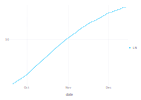

In [52]:
visualize(r, :date, :LN; kind = :line)

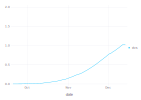

In [53]:
visualize(r, :date, :dvs; kind = :line)

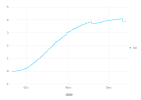

In [54]:
visualize(r, :date, :lai; kind = :line)

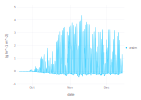

In [55]:
visualize(r, :date, :assim; kind = :line)

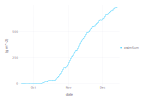

In [56]:
visualize(r, :date, :assimSum; kind = :line)

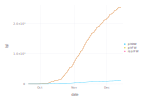

In [57]:
visualize(r, :date, [:pltDW, :pltFW, :realFW]; kind = :line)

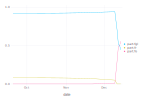

In [58]:
visualize(r, :date, ["part.fgl", "part.fr", "part.fo"]; kind = :line)

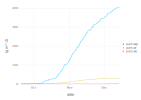

In [59]:
visualize(r, :date, ["part.wgl", "part.wr", "part.wo"]; kind = :line)